In [1]:
import requests
import pandas as pd
import json
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns

In [2]:
#get stations data, filter for CA
api_key = 'vD3YcIQ4aCof8MDagGScFZRFlGg9fVvpw1SJbvwv'

def get_charging_stations(api_key, fuel_type='ELEC', state=None, limit=10):
    base_url = 'https://developer.nrel.gov/api/alt-fuel-stations/v1.json'
    params = {
        'api_key': api_key,
        'fuel_type': fuel_type,
        'limit': limit,
        'state': state
    }
    response = requests.get(base_url, params=params)
    results = response.text
    data = response.json()
    filtered_data = data['fuel_stations']
    fuel_stations = pd.json_normalize(filtered_data,sep='_')
    return fuel_stations

charging_stations = get_charging_stations(api_key, state='CA', limit='all')

In [3]:
#drop columns, filter only public
charging_stations_simple = charging_stations[["access_code", "access_days_time", "date_last_confirmed", "fuel_type_code", "groups_with_access_code", "id", "open_date", "facility_type", "station_name", "latitude", "longitude", "city", "country", "street_address", "zip"]]
charging_stations_public = charging_stations_simple[charging_stations_simple['access_code'] == 'public'].copy()

In [4]:
charging_stations_public['zip'] = pd.to_numeric(charging_stations_public['zip'], errors='coerce')

In [8]:
# get data

#zev registrations and filter by electric
zev_county_temp = pd.read_csv("/Users/kerinapatel/desktop/CP255/Final project/New_ZEV_01-31-2024.csv")
zev_county = zev_county_temp[zev_county_temp['FUEL_TYPE'] == "Electric"].copy()

#zev reg by zip and filter by elec
zev_zip_temp = pd.read_csv("/Users/kerinapatel/desktop/CP255/Final project/zev_ZIP.csv")
zev_zip = zev_zip_temp[zev_zip_temp['FUEL_TYPE'] == "Electric"].copy()

#get CES data
calenviroscreen = pd.read_csv("/Users/kerinapatel/desktop/CP255/Final project/calenviroscreen_tracts.csv")
calenviroscreen.rename(columns={'ZIP': 'zip'}, inplace=True)

#get counties shp
california_counties = gpd.read_file('/Users/kerinapatel/desktop/CP255/Final project/ca_county_boundaries/ca_county_boundaries.shp')

In [9]:
##working on ev bar chart
# Prep make level data on EVs by filtering for 2023 data 
zev_make_2023 = zev_county[zev_county['Data_Year'] == 2023].copy()

In [10]:
# collapse data so each make has 1 row with sum of number of vehicles
zev_make_2023_collapsed = zev_make_2023.groupby('MAKE')['Number of Vehicles'].sum().reset_index()

# get top 5 makes
sorted_zev_make = zev_make_2023_collapsed.sort_values(by='Number of Vehicles', axis=0, ascending=False)
top5_zev_make = sorted_zev_make.head()

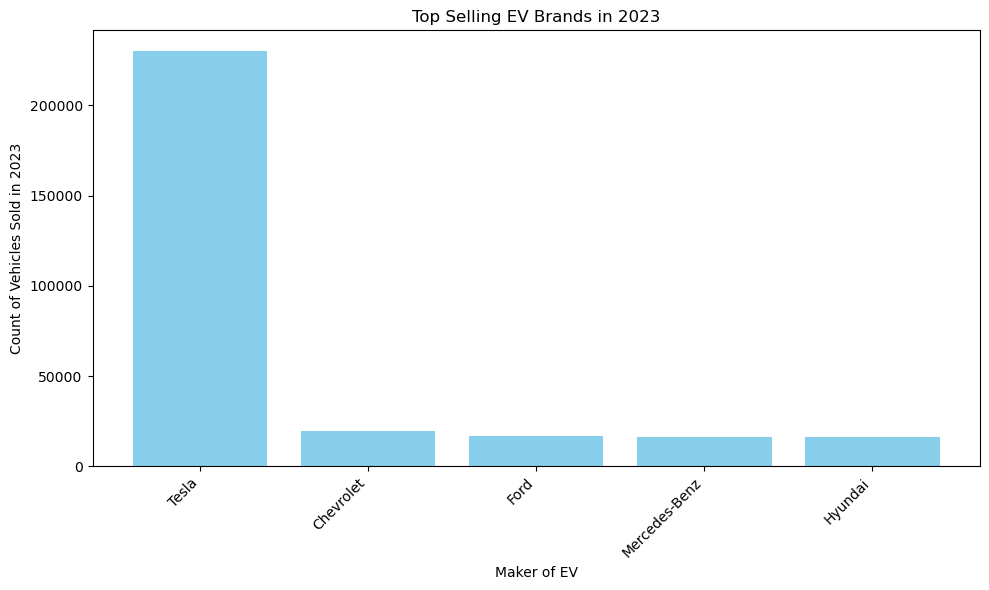

In [74]:
## bar chart of top public facility types
plt.figure(figsize=(10, 6))
plt.bar(top5_zev_make['MAKE'], top5_zev_make['Number of Vehicles'], color='skyblue')
plt.xlabel('Maker of EV')
plt.ylabel('Count of Vehicles Sold in 2023')
plt.title('Top Selling EV Brands in 2023')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() 

In [13]:
##working on chrg bar chart
# collapse charging stations so only 1 row per zip
charge_zip_collapsed = charging_stations.groupby('zip').size().reset_index(name='Number of Chargers')

In [32]:
#drop unnecessary column and filter only public chargers
charging_stations_simple = charging_stations[["access_code", "access_days_time", "date_last_confirmed", "fuel_type_code", "groups_with_access_code", "id", "open_date", "facility_type", "station_name", "latitude", "longitude", "city", "country", "street_address", "zip"]]
charging_stations_public = charging_stations_simple[charging_stations_simple['access_code'] == 'public'].copy()
charging_stations_public_zipnum = charging_stations_public.copy()
charging_stations_public_zipnum['zip'] = pd.to_numeric(charging_stations_public_zipnum['zip'], errors='coerce')

In [33]:
# pivot table chargers by facility type
chrgrs_by_type = pd.pivot_table(charging_stations, values='id', index=['facility_type'],
                       columns=['access_code'], aggfunc="count", fill_value=0)

# get top 5 public facility types
sorted_chrg_pivot = chrgrs_by_type.sort_values(by='public', axis=0, ascending=False)

# drop private column
top_public_fac=sorted_chrg_pivot.drop(columns=['private']).head()

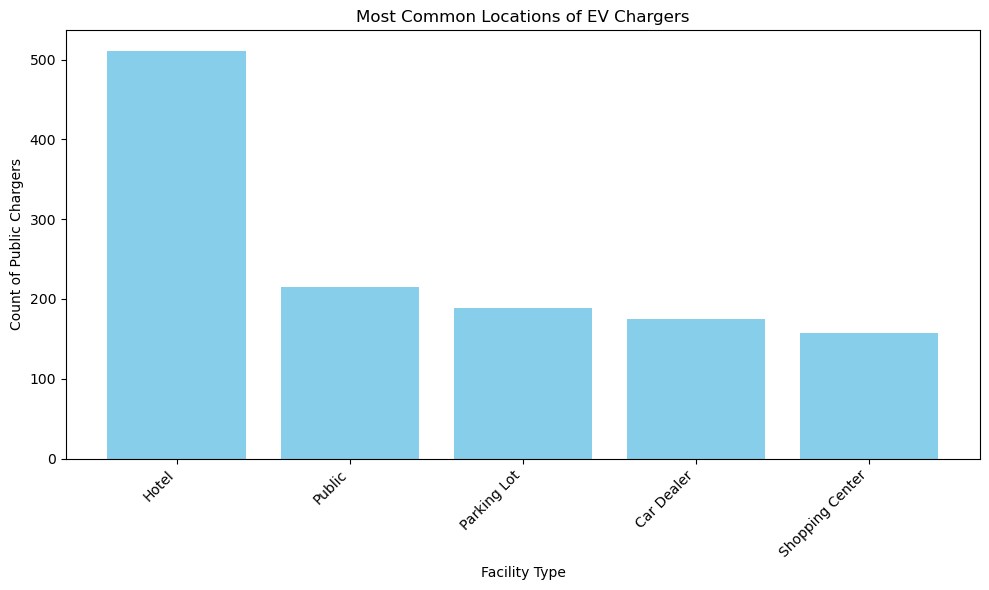

In [76]:
##chart of top public charging facility types

# fixing data axes
pivot_fix = {
    'facility_type': ['Hotel', 'Public', 'Parking Lot', 'Car Dealer', 'Shopping Center'],
    'public_count': [511, 215, 189, 175, 157]
}
public_fac_top5 = pd.DataFrame(pivot_fix)

# bar chart of top public facility types
plt.figure(figsize=(10, 6))
plt.bar(public_fac_top5['facility_type'], public_fac_top5['public_count'], color='skyblue')
plt.xlabel('Facility Type')
plt.ylabel('Count of Public Chargers')
plt.title('Most Common Locations of EV Chargers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() 

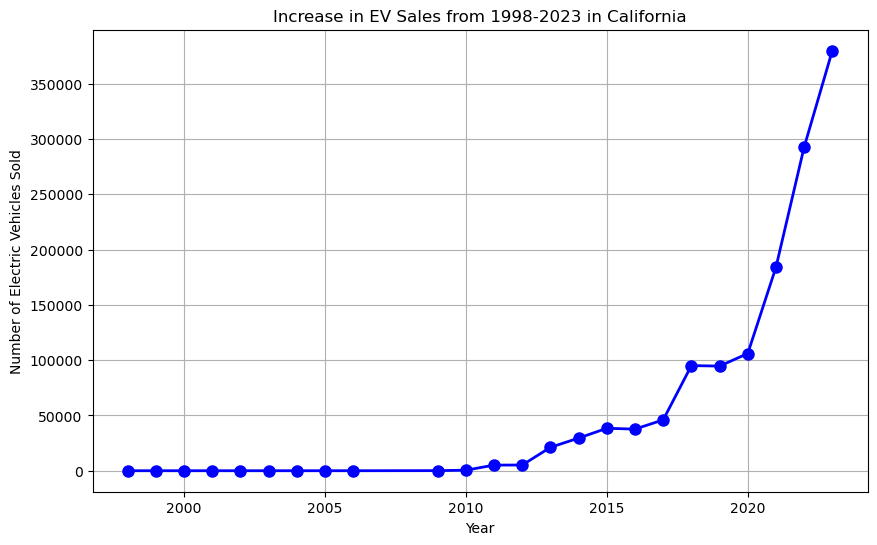

In [78]:
# EV reg over time
zev_county_collapsed = zev_county.groupby('Data_Year')['Number of Vehicles'].sum().reset_index()

plt.figure(figsize=(10, 6)) 
plt.plot(zev_county_collapsed['Data_Year'], zev_county_collapsed['Number of Vehicles'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

plt.xlabel('Year')
plt.ylabel('Number of Electric Vehicles Sold')
plt.title('Increase in EV Sales from 1998-2023 in California')
plt.grid(True)

plt.show()


In looking at the number of EVs in the state of California from 1998 to 2023, we saw a sharp increase in the adoption of EVs in the past decade. This follows based on technological advances, improving affordability of EVs, and policy changes encouraging electrification.

In [36]:
##working on ev by chrg scatterplot
# Prep zip code and county level level data on EVs by filtering for 2023 data 
zev_zip_2023 = zev_zip[zev_zip['Data_Year'] == 2023].copy()
zev_zip_2023.rename(columns={'ZIP': 'zip'}, inplace=True)

zev_county_2023 = zev_county[zev_county['Data_Year'] == 2023].copy()

In [37]:
# collapse data so each county and zip code has 1 row with sum of number of vehicles
zev_zip_2023_collapsed = zev_zip_2023.groupby('zip')['Number of Vehicles'].sum().reset_index()

zev_county_2023_collapsed = zev_county_2023.groupby('County')['Number of Vehicles'].sum().reset_index()

This chart plots the number of chargers by the number of EVs for each zip code in California. The plotted regression line and calculated R-value shows that there is a slight positive correlation. Establishing causality is a more challenging topic that future research could address.

The Correlation Coefficient (R-value) is 0.3548


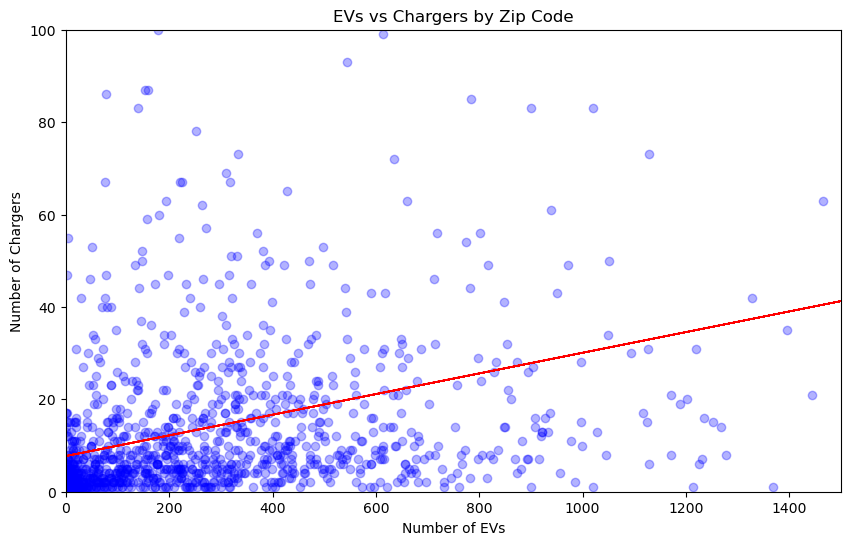

In [46]:
## Chart showing count of EV chargers by count of EV registrations on a County level - add correlation line


# count number of EV chargers in each zip code
charging_stations_by_zip =  charging_stations_public_zipnum.groupby('zip').size().reset_index(name='Number of Chargers')

# join EV chargers and EV registrations by zip code
all_ev_data = pd.merge(zev_zip_2023_collapsed, charging_stations_by_zip, on='zip', how='inner')

# subset only columns of interest
ev_data_simple = all_ev_data[["zip", "Number of Vehicles", "Number of Chargers"]]

# graph where each point is a zip code and X axis is number of EV registrations and Y is number of EV stations
plt.figure(figsize=(10, 6)) 
plt.scatter(ev_data_simple['Number of Vehicles'], ev_data_simple['Number of Chargers'], marker='o', color='blue', alpha=0.3) 

plt.xlabel('Number of EVs')
plt.ylabel('Number of Chargers')
plt.title('EVs vs Chargers by Zip Code')

# Calculate coefficients (slope and intercept) for the regression line
slope, intercept = np.polyfit(ev_data_simple['Number of Vehicles'], ev_data_simple['Number of Chargers'], 1)
plt.xlim(0, 1500)  
plt.ylim(0, 100) 

# Plot regression line
plt.plot(ev_data_simple['Number of Vehicles'], slope * ev_data_simple['Number of Vehicles'] + intercept,
         color='red', linestyle='-', linewidth=1, label='Regression Line') ## does this regression line suggest a causal relationship? 

correlation_matrix = np.corrcoef(ev_data_simple['Number of Vehicles'], ev_data_simple['Number of Chargers'])
correlation_coefficient = correlation_matrix[0, 1]  # The correlation coefficient is at position [0,1] in the matrix
print("The Correlation Coefficient (R-value) is", round(correlation_coefficient, 4))

In [40]:
## getting CES data ready for scatterplot

#rename enviro zip column
calenviroscreen.rename(columns={'ZIP': 'zip'}, inplace=True)

#drop null CES scores
calenviroscreen.dropna(subset=['CES 4.0 Score'], inplace=True)

#collapse enviroscrn data by zip
calenviro_zip_collapsed = calenviroscreen.groupby('zip')['CES 4.0 Score'].mean().reset_index(name='Avg CES 4.0 Score')


The Correlation Coefficient (R-value) is -0.0233


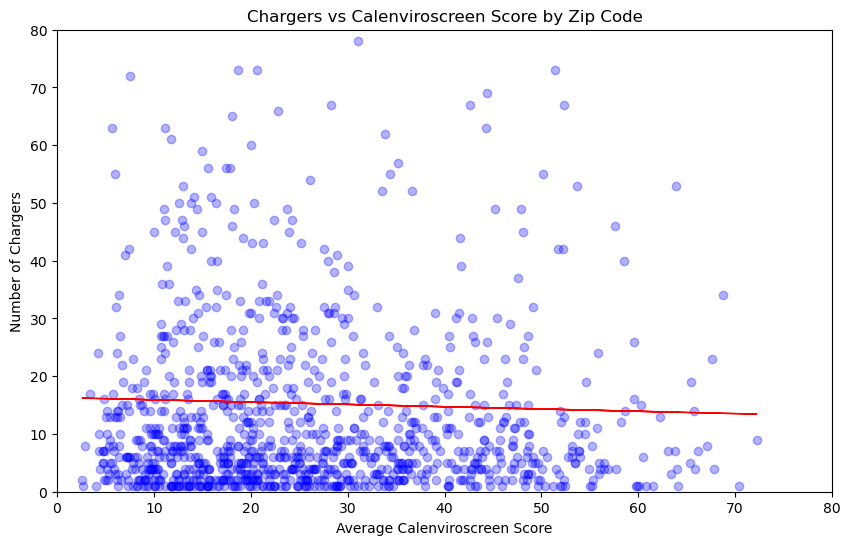

In [47]:
## scatterplot showing count of EV chargers by calenviroscreen score on a zip level - add correlation line, find R value? 


# count number of EV chargers in each zip code
charging_stations_by_zip = charging_stations_public.groupby('zip').size().reset_index(name='Number of Chargers')

# Convert 'zip' column to string in both dfs
calenviro_zip_collapsed['zip'] = calenviro_zip_collapsed['zip'].astype(str)
charging_stations_by_zip['zip'] = charging_stations_by_zip['zip'].astype(str)

# join EV chargers and enviroscreen score by zip code
chrg_ces_score_zip = pd.merge(calenviro_zip_collapsed, charging_stations_by_zip, on='zip', how='inner')

# graph where each point is a zip code and X axis is calenviroscreen score and Y is number of EV chargers
plt.figure(figsize=(10, 6)) 
plt.scatter(chrg_ces_score_zip['Avg CES 4.0 Score'], chrg_ces_score_zip['Number of Chargers'], marker='o', color='blue', alpha=0.3) 

plt.xlabel('Average Calenviroscreen Score')
plt.ylabel('Number of Chargers')
plt.title('Chargers vs Calenviroscreen Score by Zip Code')

# # # Calculate coefficients (slope and intercept) for the regression line
slope, intercept = np.polyfit(chrg_ces_score_zip['Avg CES 4.0 Score'], chrg_ces_score_zip['Number of Chargers'], 1)
plt.xlim(0, 80)  
plt.ylim(0, 80) 

# # # Plot regression line
#plt.plot(chrg_ces_score_zip['Number of Chargers'], slope * chrg_ces_score_zip['Avg CES 4.0 Score'] + intercept,
#         color='red', linestyle='-', linewidth=0.5, label='Regression Line')  
plt.plot(chrg_ces_score_zip['Avg CES 4.0 Score'], slope * chrg_ces_score_zip['Avg CES 4.0 Score'] + intercept,
         color='red', linestyle='-', linewidth=1, label='Regression Line')

correlation_matrix = np.corrcoef(chrg_ces_score_zip['Avg CES 4.0 Score'], chrg_ces_score_zip['Number of Chargers'])
correlation_coefficient = correlation_matrix[0, 1]  # The correlation coefficient is at position [0,1] in the matrix
print("The Correlation Coefficient (R-value) is", round(correlation_coefficient, 4))


In [48]:
## Chloropleth of EV Registrations - need to do density by population

In [49]:
#merge ev reg with county shp
ca_evs_2023 = california_counties.merge(zev_county_2023_collapsed, how='left', left_on='NAME', right_on='County')

In [50]:
# Density of EVs by population density!

# Get county id from GEOID
calenviroscreen['County ID'] = calenviroscreen['Census Tract'].astype(str).str[1:4]
# sum population to county level 
county_population = calenviroscreen.groupby('County ID')['Total Population'].sum().reset_index()
# Join to the ev data
ca_evs_withpop = ca_evs_2023.merge(county_population, how='left', left_on='COUNTYFP', right_on='County ID')
# calculate density
evs_by_pop = ca_evs_withpop.copy() 
evs_by_pop['EV Per Capita'] = evs_by_pop['Number of Vehicles'] / evs_by_pop['Total Population']

This first map shows the density of EVs by county in California. It would appear that Los Angeles County is the hotspot of EV adoption in the state when looking at a basic county of EVs in the county. However, when we took into account the population of the county, we found that the Bay Area emerged as a hotspot of EV concentration per capita. To calculate this, we took the number of EVs in the county and divided it by the total county population.

In [52]:
## EV charging station chloro maps

In [53]:
#geolocate chargers
chrg_pointconvert = [Point(lon, lat) for lon, lat in zip(charging_stations_simple['longitude'], charging_stations_simple['latitude'])]
chrg_stations_gdf = gpd.GeoDataFrame(charging_stations_simple, geometry=chrg_pointconvert, crs='EPSG:3857')

# copy county shp for chargers only
county_shp_charging = california_counties.copy()

# county_chrgs = county_shp_charging.merge(zev_county_2023_collapsed, how='left', left_on='NAME', right_on='County')

#Spatial join chargers to counties shp
counties_chrgs = gpd.sjoin(chrg_stations_gdf, county_shp_charging.to_crs(county_shp_charging.crs), how='inner', predicate='within')

#count number of chargers
counties_counts = counties_chrgs.groupby('NAMELSAD')['id'].count().reset_index()
county_shp_charging = pd.merge(county_shp_charging, counties_counts, on='NAMELSAD', how='left')
county_shp_charging.rename(columns={'id': 'chrgs_count'}, inplace=True)
county_shp_charging['chrgs_count'] = county_shp_charging['chrgs_count'].fillna(0)

In [54]:
# density of chargers by population density

# Get county id from GEOID
calenviroscreen['County ID'] = calenviroscreen['Census Tract'].astype(str).str[1:4]
# sum population to county level 
county_population = calenviroscreen.groupby('County ID')['Total Population'].sum().reset_index()
# Join to the charger data
chrgs_counties_withpop = county_shp_charging.merge(county_population, how='left', left_on='COUNTYFP', right_on='County ID')
# calculate density
chrgs_by_pop = chrgs_counties_withpop.copy() 
chrgs_by_pop['EV Chargers Per Capita'] = chrgs_by_pop['chrgs_count'] / chrgs_by_pop['Total Population']

In [55]:
## error work -- "not supporter btwn 'str' and 'int'"
# chrgs_counties_withpop = chrgs_counties_withpop.loc[:, ~chrgs_by_pop.columns.duplicated()]
# chrgs_counties_withpop.dtypes

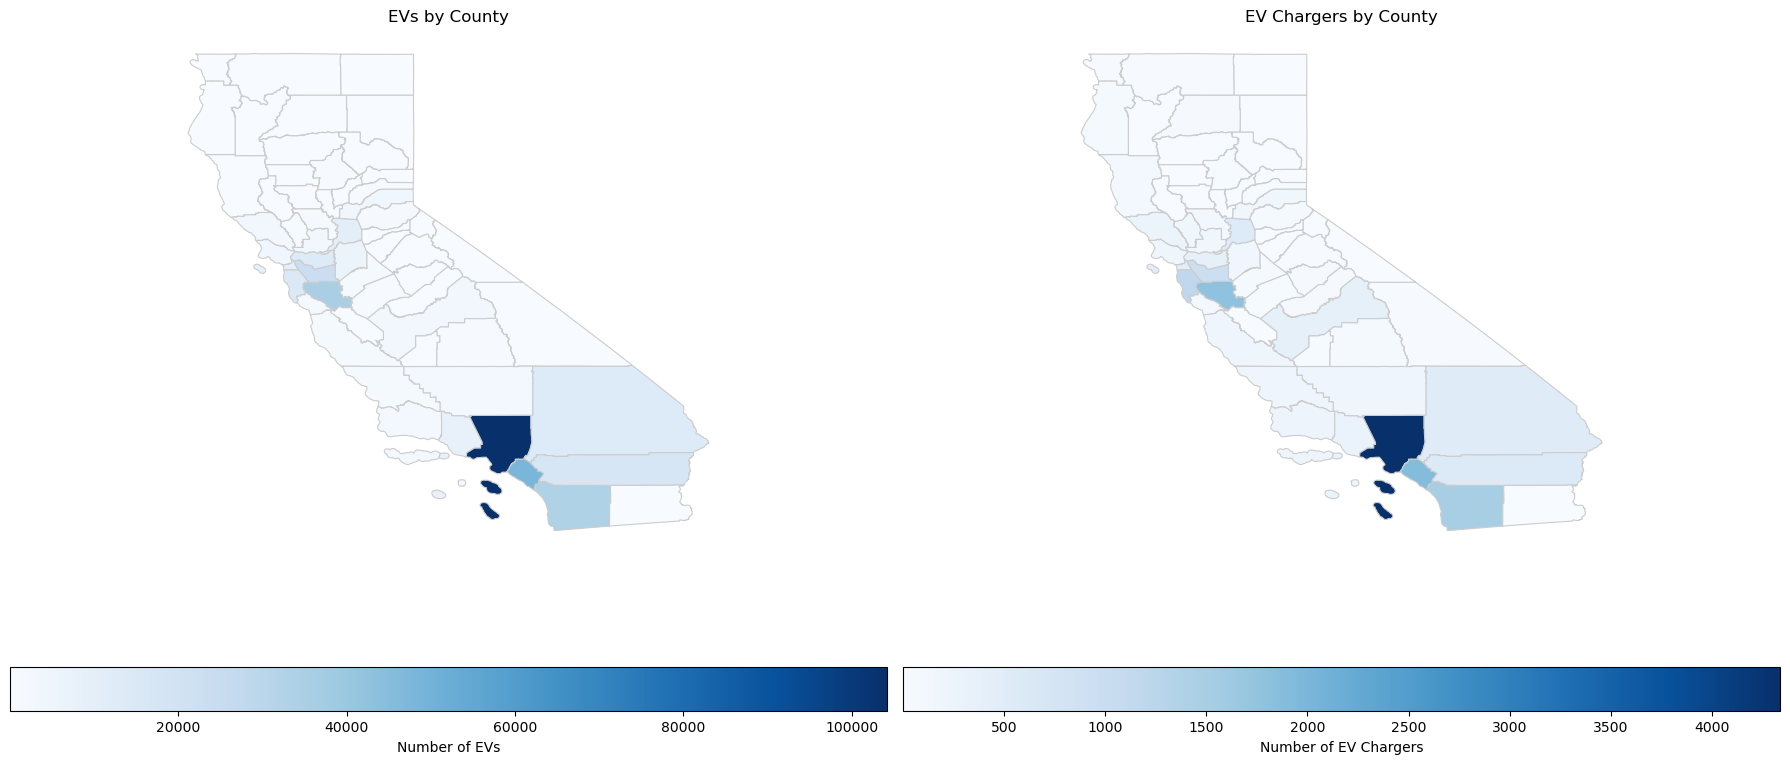

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

ca_evs_2023.plot(column='Number of Vehicles', cmap='Blues', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=True,
                 legend_kwds={'label': "Number of EVs", 'orientation': "horizontal"})
axs[0].set_title('EVs by County')
axs[0].set_axis_off()

county_shp_charging.plot(column='chrgs_count', cmap='Blues', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=True,
                         legend_kwds={'label': "Number of EV Chargers", 'orientation': "horizontal"})
axs[1].set_title('EV Chargers by County')
axs[1].set_axis_off()

plt.tight_layout()
plt.show()

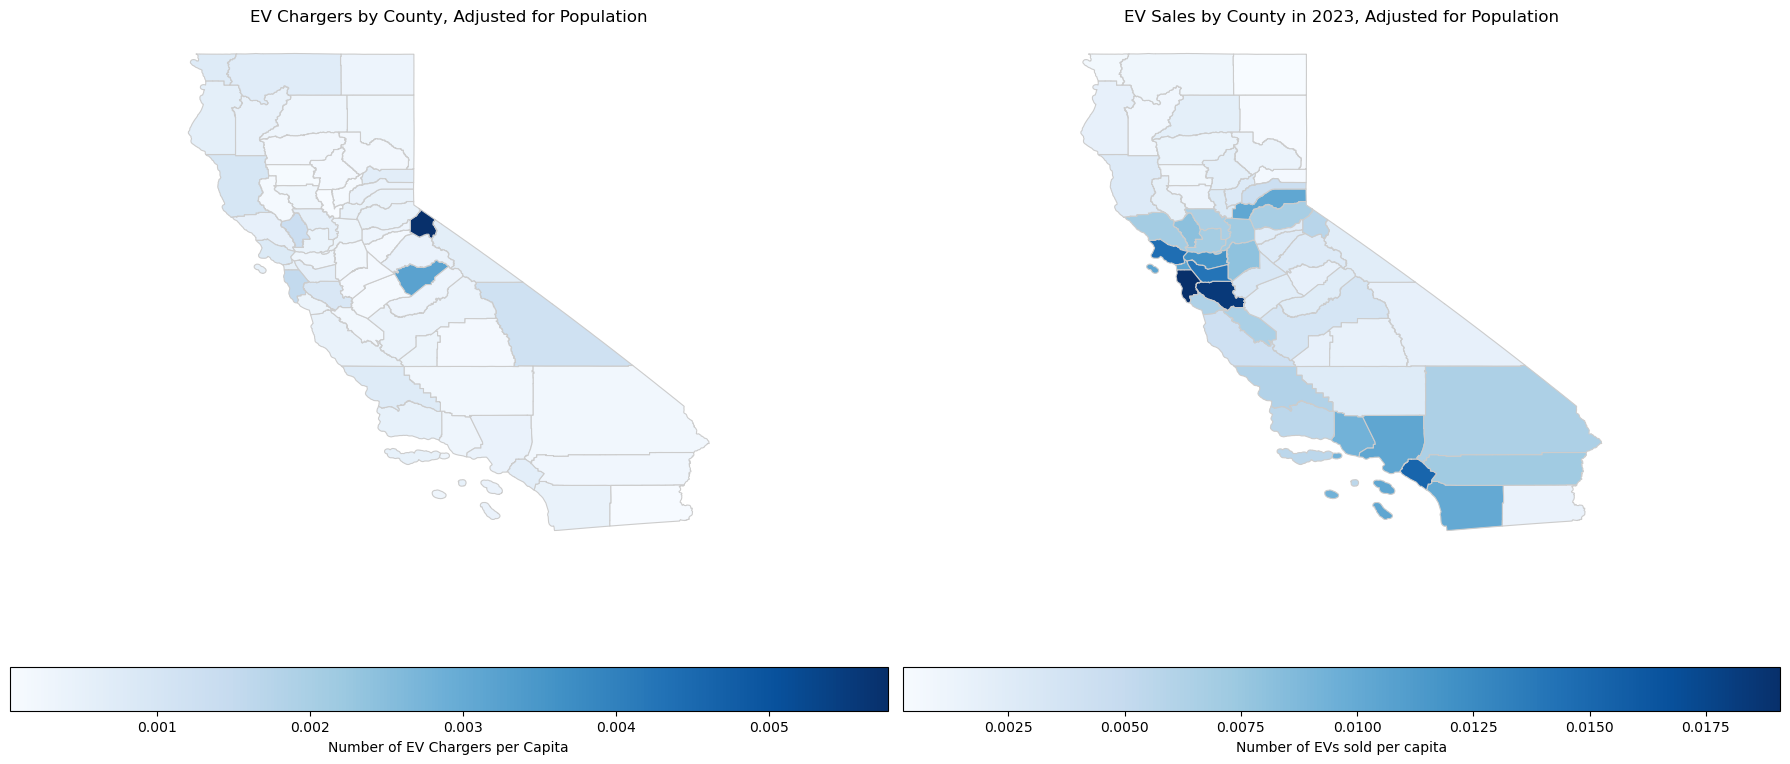

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

chrgs_by_pop.plot(column='EV Chargers Per Capita', cmap='Blues', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=True,
                  legend_kwds={'label': "Number of EV Chargers per Capita", 'orientation': "horizontal"})
axs[0].set_title('EV Chargers by County, Adjusted for Population')
axs[0].set_axis_off()

evs_by_pop.plot(column='EV Per Capita', cmap='Blues', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=True,
                legend_kwds={'label': "Number of EVs sold per capita", 'orientation': "horizontal"})
axs[1].set_title('EV Sales by County in 2023, Adjusted for Population')
axs[1].set_axis_off()

plt.tight_layout()
plt.show()